In [71]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [72]:
# Reading in the initial data

import pandas as pd
#weather = pd.read_csv("local_weather.csv", index_col="DATE")
weather = pd.read_csv('gdrive/My Drive/local_weather.csv', index_col="DATE")

In [ ]:
#check the missing data
weather.apply(pd.isnull).sum()

In [ ]:
#Check null value with a percentage
weather.apply(pd.isnull).sum()/weather.shape[0]

In [75]:
#We will select core columns for further manipulation of data

core_weather = weather[["PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]].copy()

In [76]:
#renaming selected columns
core_weather.columns = ["precip", "snow", "snow_depth", "temp_max", "temp_min"]

In [ ]:
core_weather

In [ ]:
#Filling in missing data
core_weather.apply(pd.isnull).sum()/core_weather.shape[0]

In [ ]:
core_weather["snow"].value_counts()

In [12]:
del core_weather["snow"]

In [ ]:
core_weather

In [ ]:
core_weather["snow_depth"].value_counts()

In [15]:
del core_weather["snow_depth"]

In [ ]:
core_weather

In [ ]:
#select rows were Percip is null
core_weather[pd.isnull(core_weather["precip"])]

In [ ]:
core_weather.loc["1983-10-20":"1983-11-05",:]

In [ ]:
core_weather["precip"].value_counts()

In [20]:
#replace the missing values with 0 
core_weather["precip"] = core_weather["precip"].fillna(0)

In [ ]:
core_weather["precip"]

In [22]:
#Recheck if there is missing values
core_weather[pd.isnull(core_weather["precip"])]

,precip,temp_max,temp_min
DATE,,,


In [ ]:
core_weather[pd.isnull(core_weather["temp_max"])]

In [24]:
core_weather = core_weather.fillna(method="ffill")

In [ ]:
core_weather

In [ ]:
#No missing values
core_weather.apply(pd.isnull).sum()/core_weather.shape[0]

In [ ]:
#Verifying Data Types, we check the correct data types
#Machine Learning Algorithms can only work with numeric data types
#Additionaly, having our index in the correct datetime
#format will enable us to calc predictor columns more easily.
core_weather.dtypes

In [ ]:
#Check the index
core_weather.index

In [29]:
#convert to the date_time_index
core_weather.index = pd.to_datetime(core_weather.index)

In [ ]:
core_weather.index

In [ ]:
#We can also subset to get series of data in a year,month bases
core_weather.index.year

In [ ]:
#We can also subset to get series of data in a year,month bases
core_weather.index.month

In [33]:
#Checking the data if has 9999
core_weather.apply(lambda x: (x==9999).sum())

precip      0
temp_max    0
temp_min    0
dtype: int64

### ANALYSING WEATHER DATA  


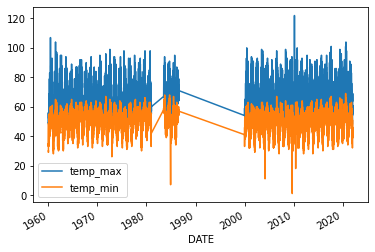

In [34]:
#Use pandas to plot TMIN and TMAX columns
core_weather[["temp_max","temp_min"]].plot()

In [ ]:
core_weather.index.year.value_counts().sort_index()

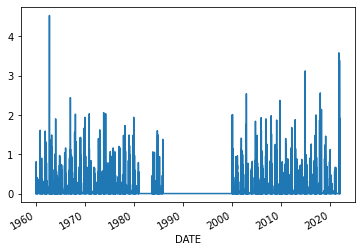

In [36]:
core_weather["precip"].plot()

In [37]:
core_weather.groupby(core_weather.index.year).sum()["precip"]

DATE
1960    14.01
1961    13.87
1962    22.47
1963    19.11
1964    16.83
1965    16.32
1966    13.11
1967    23.98
1968    17.19
1969    25.70
1970    25.31
1971    10.61
1972    16.27
1973    29.37
1974    16.87
1975    17.54
1976     8.64
1977    11.70
1978    22.57
1979    23.79
1980    13.58
1983     7.13
1984    16.03
1985     8.50
1986     0.00
2000    21.09
2001    22.84
2002    19.12
2003    11.37
2004    12.97
2005    27.37
2006    22.79
2007    12.79
2008    13.86
2009    14.57
2010    22.67
2011    16.06
2012    22.93
2013     4.89
2014    19.62
2015     8.58
2016    19.77
2017    23.34
2018    16.82
2019    20.00
2020     6.42
2021    20.82
2022     0.25
Name: precip, dtype: float64

### TRAINING AN INITIAL MODEL

In [38]:
#create a target using shift -1
core_weather["target"] = core_weather.shift(-1)["temp_max"]

In [ ]:
#we can display the dataframe
core_weather

In [40]:
#del the temp in jan 28 with NaN, the last row won't have a next day, so you won't have a target
core_weather = core_weather.iloc[:-1,:].copy()

In [41]:
core_weather

,precip,temp_max,temp_min,target
DATE,,,,
1960-01-01,0.0,49.0,30.0,49.0
1960-01-02,0.0,49.0,29.0,54.0
1960-01-03,0.0,54.0,35.0,54.0
1960-01-04,0.0,54.0,36.0,55.0
1960-01-05,0.0,55.0,33.0,53.0
...,...,...,...,...
2022-01-23,0.0,60.0,41.0,60.0
2022-01-24,0.0,60.0,39.0,57.0
2022-01-25,0.0,57.0,43.0,57.0


In [42]:
#Import machine learning library
from sklearn.linear_model import Ridge

reg = Ridge(alpha=.1)

In [43]:
predictors = ["precip","temp_max","temp_min"]

In [44]:
train = core_weather.loc[:"2020-12-31"]

In [45]:
test = core_weather.loc["2021-01-01":]

In [46]:
### Fit the model to our data
reg.fit(train[predictors], train["target"])

Ridge(alpha=0.1)

### MEASURING ACCURACY

In [47]:
predictions = reg.predict(test[predictors])

In [48]:
from sklearn.metrics import mean_absolute_error

In [49]:
mean_absolute_error(test["target"], predictions)

3.4111699434528306

In [50]:
combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)

In [51]:
combined.columns = ["actual", "predictions"]

In [52]:
combined

,actual,predictions
DATE,,
2021-01-01,57.0,59.806024
2021-01-02,56.0,59.310181
2021-01-03,62.0,58.538685
2021-01-04,59.0,61.531814
2021-01-05,59.0,59.444266
...,...,...
2022-01-23,60.0,59.985714
2022-01-24,57.0,59.626333
2022-01-25,57.0,58.181680


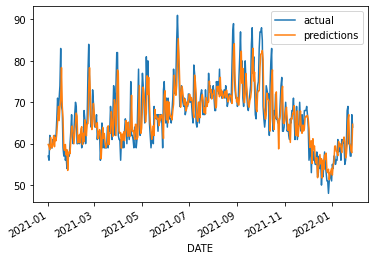

In [53]:
combined.plot()

#### Building a Prediction Function

In [54]:
def create_predictions(predictors, core_weather, reg):
    train = core_weather.loc[:"2020-12-31"]
    test = core_weather.loc["2021-01-01":]
    reg.fit(train[predictors], train["target"])
    predictions = reg.predict(test[predictors]) 
    error = mean_absolute_error(test["target"], predictions)
    combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
    combined.columns = ["actual", "predictions"]
    return error, combined

In [55]:
#create more predictors by adding in rolling means
core_weather["month_max"] = core_weather["temp_max"].rolling(30).mean()

In [56]:
core_weather

,precip,temp_max,temp_min,target,month_max
DATE,,,,,
1960-01-01,0.0,49.0,30.0,49.0,NaN
1960-01-02,0.0,49.0,29.0,54.0,NaN
1960-01-03,0.0,54.0,35.0,54.0,NaN
1960-01-04,0.0,54.0,36.0,55.0,NaN
1960-01-05,0.0,55.0,33.0,53.0,NaN
...,...,...,...,...,...
2022-01-23,0.0,60.0,41.0,60.0,56.900000
2022-01-24,0.0,60.0,39.0,57.0,57.066667
2022-01-25,0.0,57.0,43.0,57.0,57.200000


In [57]:
#remove the first 30 rows that have NaN values
core_weather = core_weather.iloc[30:,:].copy()

In [58]:
core_weather["month_day_max"] = core_weather["month_max"] / core_weather["temp_max"]

In [59]:
core_weather["max_min"] = core_weather["temp_max"] / core_weather["temp_min"]

In [60]:
predictors = ["precip", "temp_max", "temp_min", "month_max", "month_day_max", "max_min"]

In [61]:
error, combined = create_predictions(predictors, core_weather, reg)

In [62]:
error

3.3601297462076047

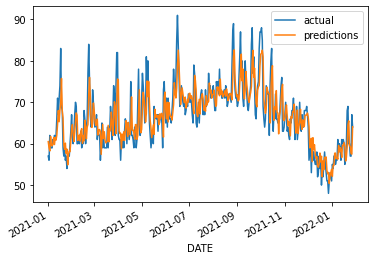

In [63]:
combined.plot()

### ADDING IN MONTHLY AND DAILY AVERAGES

In [64]:
core_weather["monthly_avg"] = core_weather["temp_max"].groupby(core_weather.index.month).apply(lambda x: x.expanding(1).mean())

In [65]:
core_weather

,precip,temp_max,temp_min,target,month_max,month_day_max,max_min,monthly_avg
DATE,,,,,,,,
1960-01-31,0.00,59.0,46.0,62.0,55.566667,0.941808,1.282609,59.000000
1960-02-01,0.81,62.0,51.0,59.0,56.000000,0.903226,1.215686,62.000000
1960-02-02,0.00,59.0,43.0,59.0,56.166667,0.951977,1.372093,60.500000
1960-02-03,0.20,59.0,47.0,60.0,56.333333,0.954802,1.255319,60.000000
1960-02-04,0.16,60.0,42.0,60.0,56.500000,0.941667,1.428571,60.000000
...,...,...,...,...,...,...,...,...
2022-01-23,0.00,60.0,41.0,60.0,56.900000,0.948333,1.463415,56.781536
2022-01-24,0.00,60.0,39.0,57.0,57.066667,0.951111,1.538462,56.783803
2022-01-25,0.00,57.0,43.0,57.0,57.200000,1.003509,1.325581,56.783955


In [66]:
core_weather["day_of_year_avg"] = core_weather["temp_max"].groupby(core_weather.index.day_of_year).apply(lambda x: x.expanding(1).mean())

In [67]:
predictors = ["precip","temp_max","temp_min", "month_max", "month_day_max", "max_min", "day_of_year_avg", "monthly_avg"]

In [68]:
error, combined = create_predictions(predictors, core_weather, reg)

In [69]:
error

3.317692658765995